In [ ]:
''' This notebook is aimed at taking in behavioral data for the designed temporal discounting paradigm. 
The output of this notebook consists of the: 
1. Logistic Regression Plots: These are used to generate the indifference points, and each delay is associated
with a binary logistic curve, from which the indifference point is estimated as the point where probability
is 0.5
2. Heatmaps: It generates the heatmaps for response time vs delay & response time vs delay as well as amount, 
since the delay is a critical variable, and subjective value is determined by delay and amount
3. Bootstraping: Multiple bootstrapping curves are generated by re-sampling from the inputs with replacement. 
This method is used to ensure that the fitting parameters are within the required bounds. 

The file reads from Cleaned_Data, and writes the output graphs to the sub-folder Plots. 
The important result from this file is the function fitting parameters:
'm' for a linear fit, 'k' for a hyperbolic fit, and beta & delta for an exponential combination fit. 
These measures of patience are written to the PatienceMeasures.csv

Created By: Aishwarya Seth
Created On: April 12th, 2022'''

In [2]:
# Import relevant files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob as glob
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import expit
from matplotlib.backends.backend_pdf import PdfPages
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Read in the files containing Choice Data
files = glob.glob("./../Cleaned_Data/Choice_[0-9]*.csv")

In [4]:
# Function for beta-delta fitting of the discounting curve
def beta_delta(x, beta, delta):
    term1 = np.exp(-(beta * x))
    term2 = np.exp(-(delta * x))
    return ((term1 + term2)/2)

In [5]:
# Function for hyperbolic fitting of the discounting curve
def hyperbola(x, k):
    return 1 / (k * x + 1)

In [6]:
# Function for linear fit of the discounting curve
def linear(x, m):
    return (m * x + 20)

In [7]:
# This is a function for creating heatmap plots from seaborn 
# The scale used is 'Blues', since a single color scheme makes the returned plots intutitive 
# and easy to understand
def create_plot(data, title = None, xlabel = None, ylabel = None, cbar_title = None):
    fig, ax = plt.subplots()
    if(cbar_title == None):
        sns.heatmap(data = data, cmap = 'Blues')
    else: 
        sns.heatmap(data = data, cmap = 'Blues', cbar_kws={'label': cbar_title})
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

# Heatmaps are generated
def generate_heatmaps(ref_id, data_for_heatmap):
    pp = PdfPages('./Plots/Heatmaps/{}_Heatmaps.pdf'.format(ref_id))
    
    # Create the subjective values from the indifference points 
    # Restrict the float precision to 2 decimal points, to achieve cleaner plots
    data_for_heatmap['subjective_value'] = [20 / x for x in data_for_heatmap['indiff_point']]
    data_for_heatmap['subjective_value'] = data_for_heatmap['subjective_value'].astype(float).round(2)
    data_for_heatmap['indiff_point'] = data_for_heatmap['indiff_point'].astype(float).round(2)

    # Thus, the variation of response time with delay is studied
    temp = data_for_heatmap.pivot_table(index = 'delays', values = 'response_time')
    create_plot(temp, title = "Delays vs Response Time", xlabel = "Response Time (s)", ylabel = "Delays (weeks)")
    pp.savefig()
    
    # Amount & Delay determine the choice in combination. Hence, the variation of 
    # responses with both amount and delay is considered
    temp = data_for_heatmap.pivot_table(index = 'amounts', columns = 'delays', values = 'response_time')
    create_plot(temp, title = "Variation in Response Times according to Amounts & Delays", xlabel = "Delays (weeks)", ylabel = "Amounts ($)", cbar_title = "Response Time (s)")
    pp.savefig()
    
    pp.close()
    
    # We observe that participants with more patience have longer response times, and vice versa, as expected
    
    
    

In [18]:
# This function generates the fit for the discounting curves (linear, hyperbolic, beta-delta exponential fit)
# The function used (optimize.curve_fit) optimizes by non-linear bounded least squares method

def generate_curve_fits(ref_id, delays, indifference_points, subjective_values):
    
    # Create the .pdf where the plots will be stored for this participant
    pp2 = PdfPages('./Plots/FitFunctions/{}_FitFunctions.pdf'.format(ref_id))
    plt.clf()
    
    try: 
        # Fit the linear function & store the parameters
        parameters, _ = optimize.curve_fit(linear, np.asarray(delays).ravel(), np.asarray(indifference_points).ravel(),  p0=[0.1], bounds = (0, [1]))
        [m] = parameters

        # Plot the linear fit
        f = plt.figure(1, figsize=(10,10))
        plt.clf()
        plt.scatter(delays, indifference_points)
        X_test = np.linspace(0, 50, 1500)

        lin = (m * X_test + 20).ravel()
        plt.plot(X_test, lin, color="red", linewidth=3)

        plt.xlabel("Delays (weeks)")
        plt.ylabel("Indifference Amount ($)")
        plt.title("Line Fitted for Participant {}".format(ref_id))
        plt.text(35, 25, 'Slope: {:.2f}'.format(m), fontsize = 12,
         bbox = dict(facecolor = 'red', alpha = 0))

        pp2.savefig(f, bbox_inches = 'tight')
        
        # Fit the hyperbolic discounting curve, and store the parameters
        parameters, _ = optimize.curve_fit(hyperbola, np.asarray(delays).ravel(), np.asarray(subjective_values).ravel(),  p0=[0.001], bounds = (0, [1]))
        [k] = parameters

        # Plot the hyperbolic fit
        f = plt.figure(1, figsize=(10,10))
        plt.clf()
        plt.scatter(delays, subjective_values)
        X_test = np.linspace(0, 100, 1500)

        hyper = 1 / (k * X_test + 1).ravel()
        plt.plot(X_test, hyper, color="red", linewidth=3)

        plt.xlabel("Delays (weeks)")
        plt.ylabel("Subjective Values (fraction of objective value)")
        plt.ylim((0, 1.2))
        plt.title("Hyperbola Fitted for Participant {}".format(ref_id))
        plt.text(70, 0.5, 'k-value: {:.2f}'.format(k), fontsize = 12,
         bbox = dict(facecolor = 'red', alpha = 0))

        pp2.savefig(f, bbox_inches = 'tight')

        # Fit the beta-delta exponential combination discounting function
        parameters, _ = optimize.curve_fit(beta_delta, np.asarray(delays).ravel(), np.asarray(subjective_values).ravel(),  p0=[0.001, 0.001], bounds = ([-1, -1], [1, 1]))
        [beta, delta] = parameters

        # Plot this exponential fit
        f = plt.figure(1, figsize=(10,10))
        plt.clf()
        plt.scatter(delays, subjective_values)
        X_test = np.linspace(0, 100, 1500)

        term1 = np.exp(-(beta * X_test))
        term2 = np.exp(-(delta * X_test))
        bd = ((term1 + term2)/2).ravel()
        plt.plot(X_test, bd, color="red", linewidth=3)

        plt.xlabel("Delays (weeks)")
        plt.ylabel("Subjective Values (fraction of objective value)")
        plt.ylim((0, 1.2))
        plt.text(70, 0.5, 'Beta: {:.2f}  \nDelta: {:.2f}'.format(beta, delta), fontsize = 12, 
         bbox = dict(facecolor = 'red', alpha = 0))
        plt.title("Beta-Delta Hyperbola Fitted for Participant {}".format(ref_id))
        

        pp2.savefig(f, bbox_inches = 'tight')
        plt.clf()
        
        pp2.close()
        
        # The returned patience parameters are returned
        return m, k, beta, delta

    except Exception as e:
        # Catch any exceptions during curve-fitting (if any)
        print(e)
        print("Exception in Curve-Fitting for Participant: ", ref_id)


In [9]:
# Bootstrapping is used to ensure that the estimated parameters are within bounds 
# This also generates the error ranges and 95% confidence intervals for all estimated parameters 
# Since the temporal discounting curve is best characterised by the hyperbolic function, 
# the graph for bootstrap results are created only for the hyperbolic fitting parameter, 'k'
# The graphs for this, which show that 'k' is within bounds, are stored in the sub-folder Bootstraps
# 500 bootstrap steps are done by default

def generate_bootstraps(ref_id, X, y_indiff, y_subjective, k_og, m_og, beta_og, delta_og, n_resamples = 500):
    
    pp = PdfPages('./Plots/Bootstraps/{}_Bootstraps.pdf'.format(ref_id))
    
    m_values = []
    k_values = []
    beta_values = []
    delta_values = []
    
    # For n_resamples, here 500, select data samples with replacement from the available data 
    # For the resamples, fit the linear, hyperbolic and beta-delta curves
    for i in range(n_resamples):
        idx = np.random.choice(np.arange(len(X)), size = len(X), replace = True)
        X_sample = X[idx]
        y_sample_indiff = y_indiff[idx]
        y_sample_subjective = y_subjective[idx]
        
        parameters, _ = optimize.curve_fit(linear, X_sample, y_sample_indiff,  p0=[0.1], bounds = (0, [1]))
        [m] = parameters
        
        parameters, _ = optimize.curve_fit(hyperbola, X_sample, y_sample_subjective,  p0=[0.001], bounds = (0, [1]))
        [k] = parameters
        
        parameters, _ = optimize.curve_fit(beta_delta, X_sample, y_sample_subjective,  p0=[0.001, 0.001], bounds = ([-1, -1], [1, 1]))
        [beta, delta] = parameters
        
        # Store the generated values
        m_values.append(m)
        k_values.append(k)
        beta_values.append(beta)
        delta_values.append(delta)
    
    # The values estimated by bootstrapping is the mean of all the generated values of fitting parameters
    m_est = np.mean(m_values)
    k_est = np.mean(k_values)
    beta_est = np.mean(beta_values)
    delta_est = np.mean(delta_values)
    
    # Plot the bootstrapping curves for 'k'
    f = plt.figure(1, figsize=(10,10))
    plt.clf()
    plt.scatter(X_sample, y_sample_subjective)
    for k_value in k_values:
        X_test = np.linspace(0, 100, 1500)
        hyper = 1 / (k_value * X_test + 1).ravel()
        plt.plot(X_test, hyper, color="black", linewidth = 1)

    X_test = np.linspace(0, 100, 1500)
    hyper = 1 / (k_og * X_test + 1).ravel()
    plt.plot(X_test, hyper, color="red", linewidth = 1)
    plt.title("Bootstraps of k for Participant {}".format(ref_id))
    
    # Ensure that the k-value is within range of the bootstrapped values 
    if((k_og >= np.min(k_values)) and (k_og <= np.max(k_values))):
        k_in_range = True
    else:
        k_in_range = False
    
    pp.savefig()
    pp.close()
    
    
    
    
    # Error values are estimated for all fitting parameters
    # Source: https://influentialpoints.com/Training/bootstrap_confidence_intervals-principles-properties-assumptions.htm
    m_err = np.std(m_values)
    k_err = np.std(k_values)
    beta_err = np.std(beta_values)
    delta_err = np.std(delta_values)
    
    # Confidence interval are estimated for all fitting parameters
    # Source: https://influentialpoints.com/Training/bootstrap_confidence_intervals-principles-properties-assumptions.htm
    m_95_CI_lowerbound = np.quantile(m_values, 0.025)
    m_95_CI_upperbound = np.quantile(m_values, 0.975)
    
    k_95_CI_lowerbound = np.quantile(k_values, 0.025)
    k_95_CI_upperbound = np.quantile(k_values, 0.975)
    
    beta_95_CI_lowerbound = np.quantile(beta_values, 0.025)
    beta_95_CI_upperbound = np.quantile(beta_values, 0.975)
    
    delta_95_CI_lowerbound = np.quantile(delta_values, 0.025)
    delta_95_CI_upperbound = np.quantile(delta_values, 0.975)
              
    # Store off the values that are found by bootstrapping
    dict_values = {'m_est': m_est, 'm_err': m_err, 'm_95_CI_lowerbound': m_95_CI_lowerbound, 
                   'm_95_CI_upperbound': m_95_CI_upperbound, 
                   'k_est': k_est, 'k_err': k_err, 'k_95_CI_lowerbound': k_95_CI_lowerbound, 
                   'k_95_CI_upperbound': k_95_CI_upperbound, 'k_in_range': k_in_range,
                   'beta_est': beta_est, 'beta_err': beta_err, 'beta_95_CI_lowerbound': beta_95_CI_lowerbound, 
                   'beta_95_CI_upperbound': beta_95_CI_upperbound, 
                   'delta_est': delta_est, 'delta_err': delta_err, 'delta_95_CI_lowerbound': delta_95_CI_lowerbound, 
                   'delta_95_CI_upperbound': delta_95_CI_upperbound, 
                   'RefID': ref_id
                  }
    
    # Results are written for each participant as ParameterEstimates
    df_estimates = pd.DataFrame(dict_values, index = [0])
    df_estimates.to_csv("./ParticipantEstimates/{}_ParameterEstimates.csv".format(ref_id), index = False)

In [15]:
# For each participant, create logistic regression fits for each delay 
# From these curves, the indifference point is the point at which the probability is 0.5
# At the indifference point, or the point of indecision, the participant is equally likely to say 0 or 1
def generate_indifference_points(ref_id, df): 
    
    pp = PdfPages('./Plots/LogisticRegressionPlots/{}_FitLRPlots.pdf'.format(ref_id))
    plt.clf()
    
    p = 0.5
    
    # Colors are defined for the different delay curves
    delay_color = {1: 'blue', 2:'orange', 4: 'green', 12: 'red', 24: 'purple', 52: 'brown'}
    delays = []
    indifference_points = []
    avg_durations = []
    amt_grouped = []
    indiff_grouped = []
    delay_grouped = []
    
    # For a given participant, group together their responses by delay i.e. build an LR plot for one delay
    groups = df.groupby(by = ['Delay'])
    for group in groups:
        # For this delay, create a scatter plot, showing the location of the amounts and responses 
        clf = LogisticRegression(C=1e5)
        f = plt.figure(1, figsize=(10,10))
        plt.scatter(np.array(group[1]['Amount']).ravel(), group[1]['response'], color=delay_color[group[0]], zorder=10)
        X_test = np.linspace(0, 150, 500)
        plt.xlabel("Larger, Delayed Amount ($)")
        plt.ylabel("Responses")
        plt.title("Delay: {} weeks for Participant {}".format(group[0], ref_id))
    
        # Extract the list of amounts and responses for the participant (used for logistic regression fitting)
        amounts = group[1]['Amount']
        responses = group[1]['response']
        
        # Ref: https://gist.github.com/adelavega/5938057
        # If the subject said later to all (always picked 1), assume indifference point is low
        # Then, a reasonable assumption is that they would pick $20 now over $0 now, and this is 
        # represented by adding in the choice 0 for delay 0 and amount 0
        if (np.mean(group[1]['response']) == 1):
            amounts = np.append(amounts, 0)
            responses = np.append(responses, 0)
        
        # If the subject said now to all (always picked 0), assume indifference point is higher than $130
        # This is set to some arbitrarily high amount (Here, $300 is taken as it is double of $130)
        # We assume that the participant will choose option 1 if the amount is sufficiently high
        elif (np.sum(group[1]['response']) == 0):
            amounts = np.append(amounts, 300)
            responses = np.append(responses, 1)
 
        # Once we have the amounts and responses, the logistic regression curve is fit 
        clf.fit(np.array(amounts).reshape(-1, 1), responses)
        loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
        
        # The indifference point is calculated as the point at which probability is 0.5
        # Ref for calculation: https://stackoverflow.com/questions/32040504/regression-logistic-in-r-finding-x-value-predictor-for-a-particular-y-value
        indifference_point = (np.log(p/(1-p)) - clf.intercept_)/clf.coef_
            
        # Plot the logistic regression curve
        plt.plot(X_test, loss, color=delay_color[group[0]], linewidth=3)
        pp.savefig(f, bbox_inches='tight')

        # Save off the delays and indifference points 
        delays.append(group[0])
        indifference_points.append(indifference_point)
        
        # In order to generate the heatmaps, we need to know what amounts & delays are associated 
        # with a particular indifference point 
        # For a given delay (group[0]), the amount is noted
        # The mean response time for the (amount,delay) combination is stored 
        # Thus the indifference point, amount, delay and response time are stored as a combination
        # This information can be used to generate heatmaps 
        amt_groups = group[1].groupby(by = 'Amount')
        for amt_group in amt_groups:    
            amt_grouped.append(amt_group[0])
            avg_durations.append(np.mean(amt_group[1]['duration_in_seconds']))
            delay_grouped.append(group[0])
            indiff_grouped.append(indifference_point)
    
    # Create a plot for all the delay curves in a single plot
    plt.ylabel("Responses")
    plt.title("All Delays for Participant {}".format(ref_id))
    plt.gca().legend(('1 week','2 weeks', '4 weeks', '12 weeks', '24 weeks', '52 weeks'), title = "Delay (in weeks)", loc = 'center right')
    pp.savefig(f, bbox_inches='tight')
    pp.close()
    
    # Store off data for the heatmap as described above
    heat_dict = {'response_time': avg_durations, 'indiff_point': indiff_grouped, 'amounts': amt_grouped, 'delays': delay_grouped}
    data_for_heatmap = pd.DataFrame(heat_dict)
    
    # At a delay of 0, the participants choose an amount of $20, which is stored as the indifference point
    # This is in accordance with the description in Kable & Glimcher (2007)
    delays.append(0)
    indifference_points.append(20)
    
    # Subjective values are taken as a ratio of the indifference points 
    # This now incorporates the effect of both amount and delay while making a choice
    subjective_values = [20 / x for x in indifference_points]
    
    return delays, indifference_points, subjective_values, data_for_heatmap

Completed Data Generation for Participant:  8
Completed Data Generation for Participant:  9
Completed Data Generation for Participant:  10
Completed Data Generation for Participant:  2
Completed Data Generation for Participant:  3
Completed Data Generation for Participant:  1
Completed Data Generation for Participant:  4
Completed Data Generation for Participant:  5
Completed Data Generation for Participant:  7
Completed Data Generation for Participant:  6


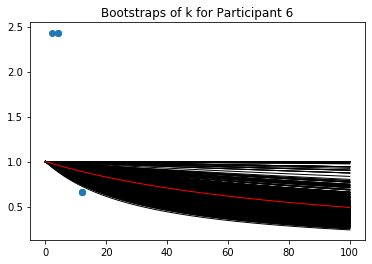

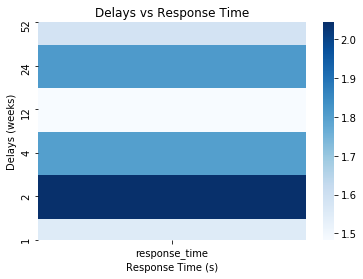

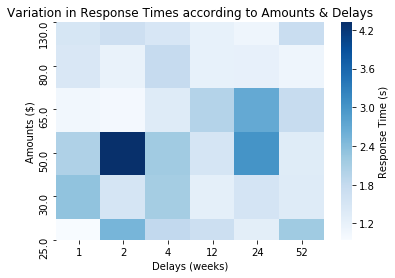

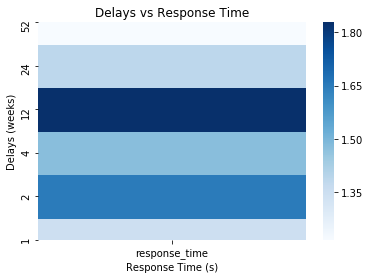

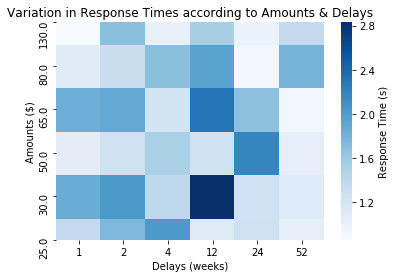

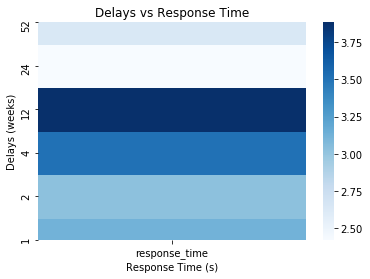

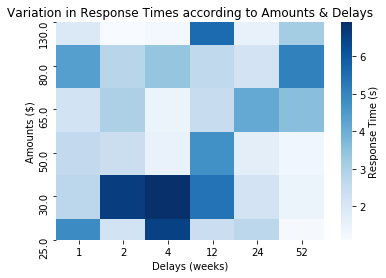

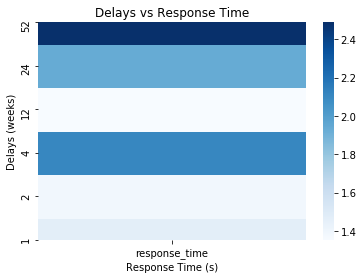

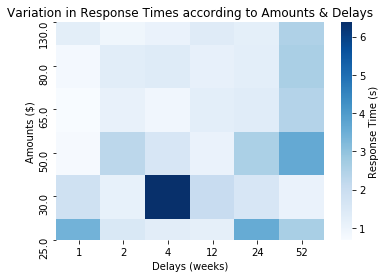

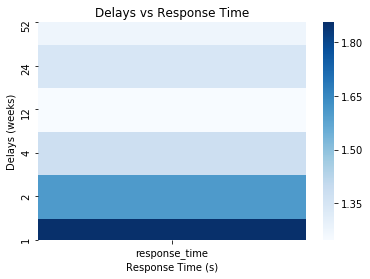

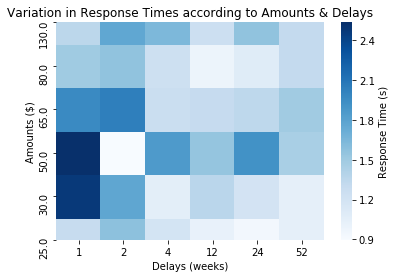

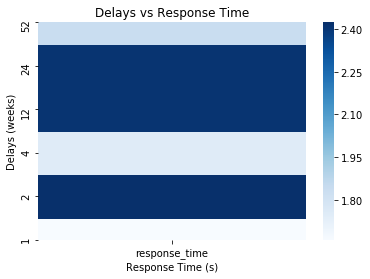

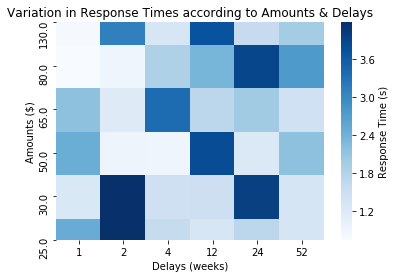

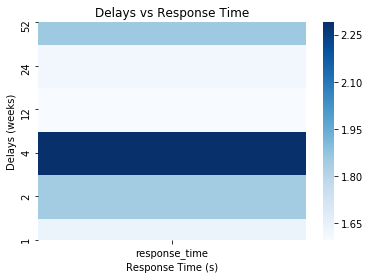

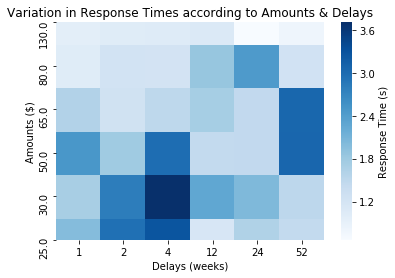

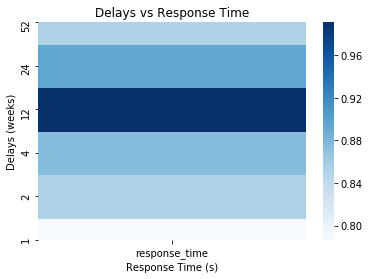

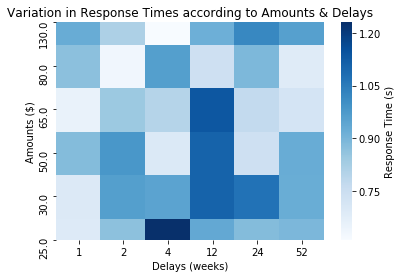

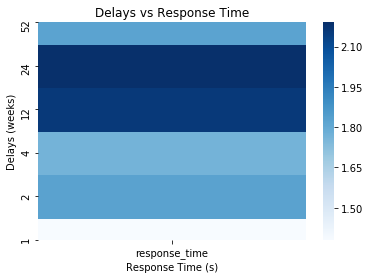

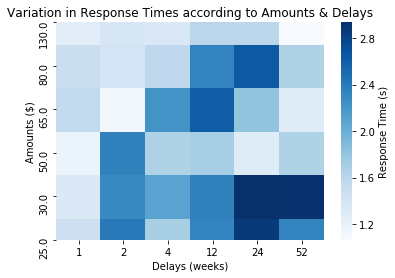

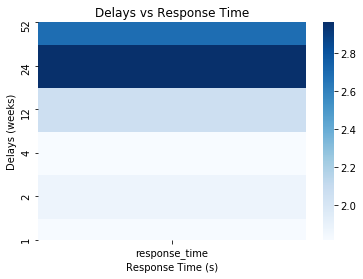

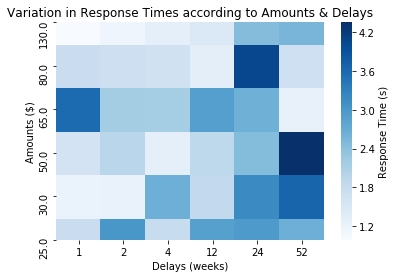

In [11]:
ref_ids = []
k_values = []
beta_values = []
delta_values = []
m_values = []

for file in files: 
    # For each file, identify the participant by their reference ID, and read in the information
    ref_id = file.split("_")[-1][:-4]    
    df = pd.read_csv(file)

    # Find their indifference points and plot the logistic regression curves
    delays, indifference_points, subjective_values, data_for_heatmap = generate_indifference_points(ref_id, df)
        
    # Fit the curves according to the calculated indifference points, delays, and subjective values 
    m, k, beta, delta = generate_curve_fits(ref_id, delays, indifference_points, subjective_values)
    
    # Save off the parameters returned
    ref_ids.append(ref_id)
    m_values.append(m)
    k_values.append(k)
    beta_values.append(beta)
    delta_values.append(delta)

    # Create the heatmaps for the variations of delays, amounts and response times
    generate_heatmaps(ref_id, data_for_heatmap)
    
    # Bootstrapping is used to validate the fit
    generate_bootstraps(ref_id, np.asarray(delays).ravel(), np.asarray(indifference_points).ravel(), np.asarray(subjective_values).ravel(), k, m, beta, delta, n_resamples = 500)
    
    print("Completed Data Generation for Participant: ", ref_id)
    #break

In [14]:
# The patience measures calculated are written off to a common .csv file
dictionary = {'RefID': ref_ids, 'Fitting_Param_m': m_values, 'Fitting_Param_k': k_values, 'Fitting_Param_Beta': beta_values, 'Fitting_Param_Delta': delta_values}
df_output = pd.DataFrame(dictionary)
df_output.to_csv("PatienceMeasures.csv", index = False)